# Visualising trials from Fast AutoAugment
- version: revision_1

In this notebook, I aim to understand how Fast AutoAugment found the optimal data augmentation policies for CIFAR-10 dataset.

In the bayesian optimisation loop I implemented, at each round the evaluation function receives a policy that contains 5 sub-policies. Each sub-policy is consist of two consecutive image augmentation operations. The goal of the bayesian optimisation is to find probability $p$ and magnitude $\lambda$ for the chosen operations. 

TPE algorithm of HyperOpt searches the optimal values of $p$ and $\lambda $ of the operations that minimizes their validation errors. The tried values and their corresponding validation errors are saved as Trials. So it'd be interesting to see how HyperOpt picked values to examine and how it reached the optimal point.

To focus on an operation at a time, I de-coupled the operations with the validation error of their policies. This might weaken the interpretation but it shows the general trend. 

In [1]:
import os
import pickle
from collections import defaultdict
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cv_folds = 5
search_width = 2
search_results_folder = 'fastautoaugment'

In [3]:
records = []

for k_idx in range(cv_folds):

    T_star_k_idx = []

    for t_idx in range(search_width):
        trials = pickle.load(
            open(os.path.join(search_results_folder, "k{}_t{}_trials.pkl".format(k_idx, t_idx)), "rb"))

        val_error_list = [t['result']['loss'] for t in trials.trials]
        trial_records = [t['misc']['vals'] for t in trials.trials]
        
        for ops, loss in zip(trial_records, val_error_list):
            for op, val in ops.items():
                _, op_name, op_type = op.split("_")
                records.append({"op_name": op_name,
                "op_type": op_type,
                "val": val[0],
                "loss": loss})

In [4]:
records_df = pd.DataFrame(records)
pivoted = pd.pivot_table(records_df, index=['op_name', 'loss'], columns='op_type').reset_index()

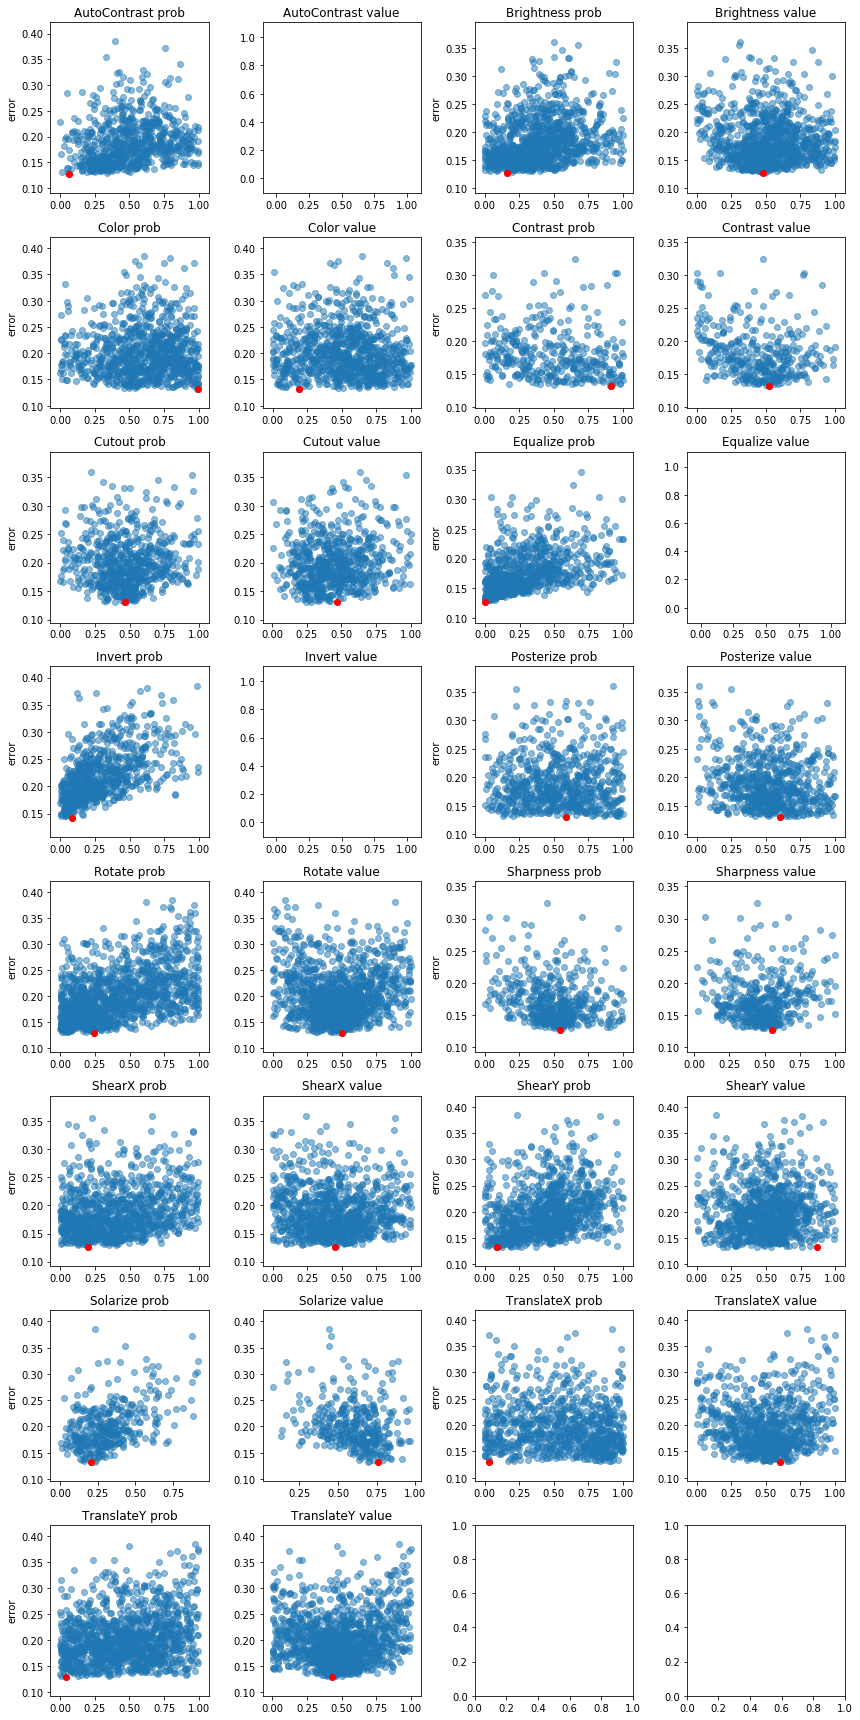

In [5]:
g = pivoted.groupby('op_name')

fig, ax = plt.subplots(8, 4, figsize=(12, 24))

for idx, (label, data) in enumerate(g):
    
    nrow = idx // 2
    isEven = int((idx+1) % 2 == 0)
    
    minimum_record = data.iloc[np.argmin(np.array(data.loss))]
    
    ax[nrow, isEven*2].scatter(data.val.p, data.loss, alpha=0.5)
    ax[nrow, isEven*2].scatter(minimum_record.val.p, minimum_record.loss, color='red')
    if not data.val.v.iloc[0] == 'None':
        ax[nrow, isEven*2+1].scatter(data.val.v, data.loss, alpha=0.5)
        ax[nrow, isEven*2+1].scatter(minimum_record.val.v, minimum_record.loss, color='red')
    ax[nrow, isEven*2].set_title(label + " prob")
    ax[nrow, isEven*2+1].set_title(label + " value")
    
    ax[nrow, isEven*2].set_ylabel("error")
    
#     ax[nrow, isEven*2].set_ylim(0.1, 0.2)
#     ax[nrow, isEven*2+1].set_ylim(0.1, 0.2)
plt.tight_layout()    
plt.show()